291
291
562.1659443
Optimization terminated successfully.
         Current function value: 391.959253
         Iterations: 33
         Function evaluations: 60
[ 0.31990532  0.63040207]


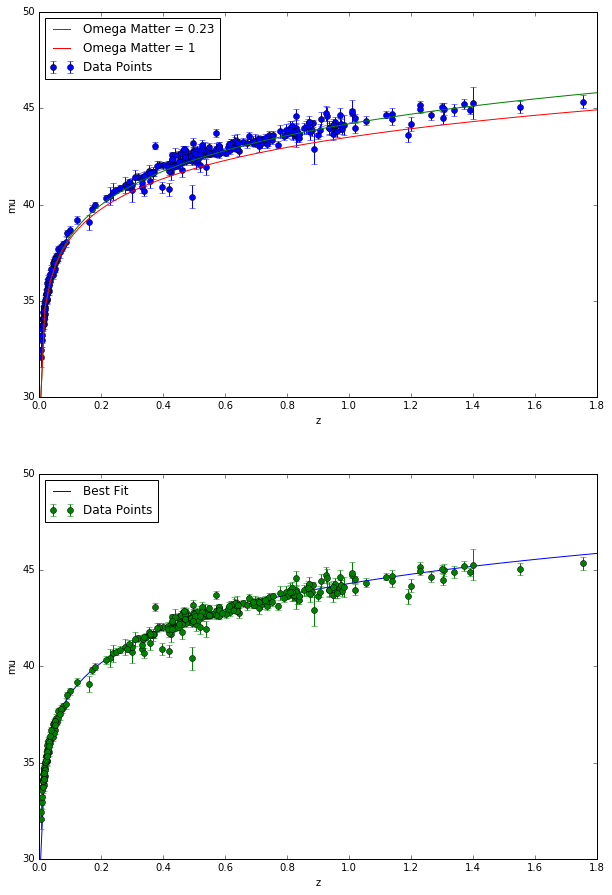

In [7]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.optimize import curve_fit
from scipy.optimize import fmin
import scipy.integrate as integrate

with open("SN.dat") as textfile:
    lines = [line.split() for line in textfile]

#print lines

redshift = np.zeros(291)
distMod = np.zeros(291)
sigma = np.zeros(291)

for i in range(0, 290):
    redshift[i] = float(lines[i][1])
    distMod[i] = float(lines[i][2])
    sigma[i] = float(lines[i][3])
    #print sigma[i]    
    
fig = plt.figure(1, figsize=(10,40))

ax = fig.add_subplot(511)
plt.ylim([30,50])

plt.xlabel("z")
plt.ylabel("mu")

plt.errorbar(redshift, distMod, yerr = sigma, fmt='-o', linestyle = 'None', label='Data Points')
    
count = 100

zpoints = np.linspace(0.001,1.8,count)

def get_dDldzStar(z, omegaM):
    return 3000 * 1/((1+z)**(3.)*omegaM + (1 - omegaM))**(1./2.)

DlStar1 = np.zeros(count)
DlStar2 = np.zeros(count)

for i in range(count):
    z = zpoints[i]
    a1 = integrate.quad(get_dDldzStar, 0, z, args =(0.23))
    a2 = integrate.quad(get_dDldzStar, 0, z, args =(1))
    DlStar1[i] = (1+z)*a1[0]
    DlStar2[i] = (1+z)*a2[0]
    
print len(distMod)
print len(redshift)

def get_mu(z, OmegaM, h):
    a1 = integrate.quad(get_dDldzStar, 0, z, args =(OmegaM))
    dls = (1+z)*a1[0]
    get_mu = 25 - 5*np.log10(h) + 5*np.log10(dls)
    return get_mu

mu1 = np.zeros(count)
mu2 = np.zeros(count)

for i in range(count):
    mu1[i] = get_mu(zpoints[i], 0.23, 0.7)
    mu2[i] = get_mu(zpoints[i], 1., 0.7)
    

ax.plot(zpoints, mu1, label = "Omega Matter = 0.23")
ax.plot(zpoints, mu2, label = "Omega Matter = 1")
legend = plt.legend(loc='upper left')

def get_chi2(params, z, s):
    OmegaM, h = params
    chi2 = 0.0
    for i in range(290):
        chi2 += ((distMod[i] - get_mu(redshift[i], OmegaM, h))**2)/s[i]**2
    return chi2

best = ([0.23, 0.7])

print get_chi2(best, zpoints, sigma)
opt = fmin(get_chi2, best, args=(redshift, sigma), maxfun = 10000000)
print opt

ax2 = fig.add_subplot(512)
muBest = np.zeros(count)

for i in range(count):
    muBest[i] = get_mu(zpoints[i], opt[0], opt[1])

ax2.plot(zpoints, muBest, label= "Best Fit")
plt.ylim([30,50])

plt.xlabel("z")
plt.ylabel("mu")

plt.errorbar(redshift, distMod, yerr = sigma, fmt='-o', linestyle = 'None', label="Data Points")
legend = plt.legend(loc='upper left')

plt.show()

2(b) The line given by $\Omega_{m} = 0.23$ is a much better fit than the line given by $\Omega_{m} = 1$.

3(a) To get the best fit model I would minimize the $\chi^{2}$ function to find values of $h$ and $\Omega_{m}$. These values should produce the best fit model, as $\chi^{2}$ is an indication of how well the model fits the data, with lower values corresponding to a smaller variance between the data and the theoretical model produced using those values of $h$ and $\Omega_{m}$. From question 2 I found that $\Omega_{m} = 0.23$ and $h = 0.7$ fit the data fairly well. These points can be used as initial guesses.

3(c) The best fit model is $\Omega_{m} = 0.32$ and $h = 0.63$. My $\chi^{2}$ divided by the number of data points is 1.34, which indicates an acceptable fit. If this number was much greater than 1 then the fit would not be acceptable.

4(a) Using the problem from question 3, we should search for a maximum likelihood using $L \propto e^{-\frac{1}{2}\chi^{2}}$. Any constants can be ignored because they do not affect the location of the maximum value.

Mean acceptance fraction: 0.707


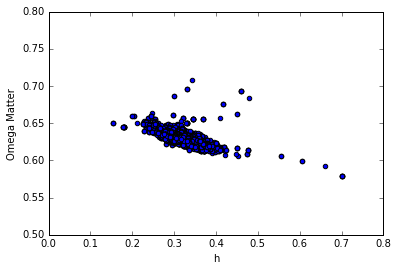

In [5]:
import numpy as np
import emcee

def lnprob(params, z, s): #supply log likelyhood
    OmegaM, h = params
    if OmegaM < 0 or OmegaM > 1:
        return -1e200
    if h < 0 or h > 1:
        return -1e200
    return -get_chi2(params, z, s)/2

ndim = 2

nwalkers = 10

p0 = np.random.rand(ndim*nwalkers).reshape((nwalkers, ndim))
#p0 = [np.random.rand(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(redshift, sigma))

pos, prob, state = sampler.run_mcmc(p0,10)
sampler.reset()

sampler.run_mcmc(pos, 1000, rstate0 = state)

print("Mean acceptance fraction: {0:.3f}"
                .format(np.mean(sampler.acceptance_fraction)))

plt.figure()
plt.scatter(sampler.flatchain[:,0], sampler.flatchain[:,1])
plt.xlim(0, .8)
plt.ylim(.5,.8)
plt.xlabel('h')
plt.ylabel('Omega Matter')
plt.show()

4(c) By using MCMC in addition to minimalization we can get errors on our values of $\Omega_{m}$ and $h$. Straight minimalization gives us best fit values but no concept of how precise these values are. 

4(d) From these simulations, my current cosmological model is:
$$\Omega_{m} = 0.32 \pm 0.03$$
$$\Omega_{\Lambda} = 0.68 \pm 0.03$$
$$h = 0.63 \pm 0.14$$

My calculation of h is lower than the currently accepted value of $h = 0.70 \pm 0.22$. My calculations of $\Omega_{m}$ and $\Omega_{\Lambda}$ are close to but still in disagreement with the currently accepted values given by $\Omega_{\Lambda} = 0.6911 \pm 0.0062$.
